<a href="https://colab.research.google.com/github/baby1146/baby1146/blob/main/Air_Passengers_Time_Series_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading the basic libraries

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA

## Loading AirPassenger data set

In [4]:
airpass_df = pd.read_csv('AirPassengers.csv')

In [5]:
airpass_df.head(5)

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [6]:
airpass_df.rename(columns={'#Passengers':'Passengers'},inplace=True)

In [7]:
airpass_df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [8]:
airpass_df.shape

(144, 2)

In [9]:
airpass_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Month       144 non-null    object
 1   Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [10]:
airpass_df.isnull().sum()

,0
Month,0
Passengers,0


In [11]:

airpass_df['Month']=pd.to_datetime(airpass_df['Month'],infer_datetime_format=True)

In [12]:
airpass_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       144 non-null    datetime64[ns]
 1   Passengers  144 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB


In [13]:
# indexing the month column
airpassind_df = airpass_df.set_index('Month',inplace=False)

In [14]:
airpassind_df

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


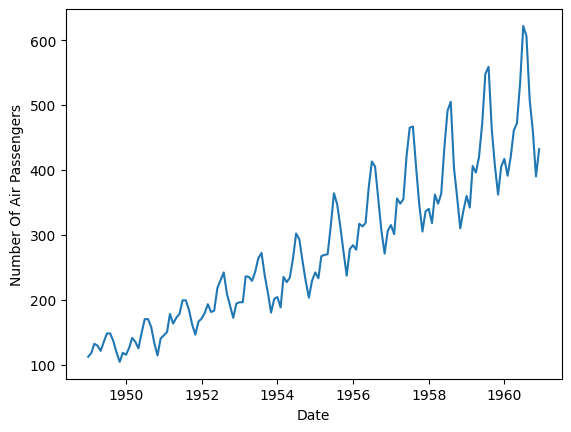

In [15]:
plt.xlabel('Date')
plt.ylabel('Number Of Air Passengers')
plt.plot(airpassind_df)

From the above below, we can see that there is a Trend compoenent in the series. Hence, we now check for stationarity of the data.


Let's make one function consisting of stationary data checking and ADCF test working. Because we will need to repeat the steps many times, therefore, making function will become very handy



In [16]:
def test_stationarity(timeseries):

    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()

    #Plot rolling statistics
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(movingAverage, color='red', label='Rolling Mean')
    plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    airpass_test = adfuller(timeseries['Passengers'], autolag='AIC')
    dfoutput = pd.Series(airpass_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in airpass_test[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

Let's determine & plot rolling statistics.

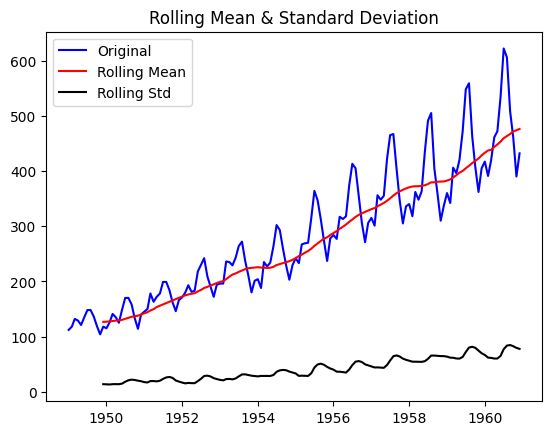

Results of Dickey Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [17]:
test_stationarity(airpassind_df)

From above plot, we can see that Rolling Mean itself has a trend component even though Rolling Standard Deviation is fairly constant with time.

For time series to be stationary, we need to ensure that both Rolling Mean and Rolling Standard Deviation remain fairly constant WRT time.

Both the curves needs to be parallel to X-Axis, in our case it is not so.

We've also conducted the ADCF ie Augmented Dickey Fuller Test. Having the Null Hypothesis to be Time Series is Non Stationary.

For a Time series to be stationary, the ADCF test should have:

p-value should be low (according to the null hypothesis)
The critical values at 1%,5%,10% confidence intervals should be as close as possible to the Test Statistics
From the above ADCF test result, we can see that p-value(near to 1.0) is very large. Also critical values are no where close to the Test Statistics. Hence, we can safely say that our Time Series at the moment is NOT STATIONARY

## Data Transformation To Achieve Stationarity
Now, we will have to perform some data transformation to achieve Stationarity. We can perform any of the transformations like taking log scale, square, square root, cube, cube root, time shift, exponential decay, etc.

Let's perform Log Transformation.

Basically we need to remove the trend component.

In [18]:
airpass_log = np.log(airpassind_df)

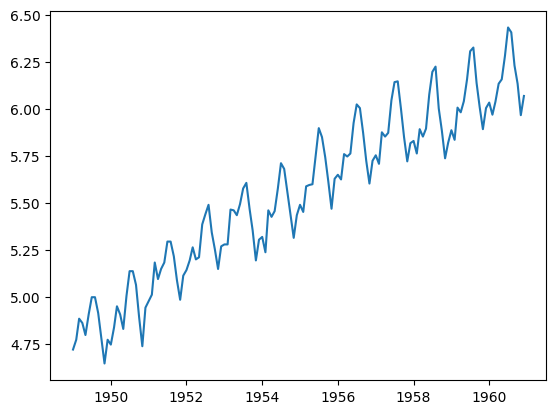

In [19]:
plt.plot(airpass_log)

Working on Rolling stats seperately (not using function) because we would need Rolling stats separately for computing

In [20]:
rollmean_log = airpass_log.rolling(window=12).mean()
rollstd_log = airpass_log.rolling(window=12).std()

Text(0.5, 1.0, 'Rolling Mean & Standard Deviation (Logarithmic Scale)')

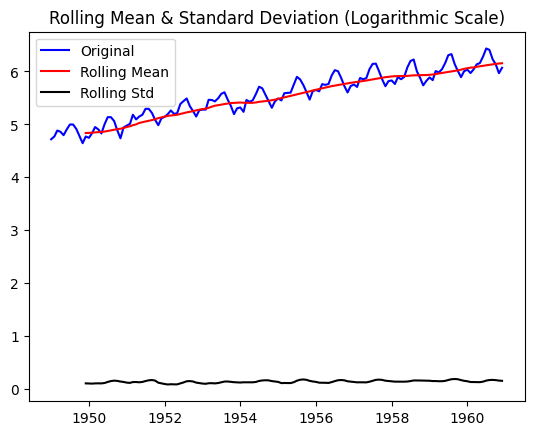

In [21]:
plt.plot(airpass_log, color='blue', label='Original')
plt.plot(rollmean_log, color='red', label='Rolling Mean')
plt.plot(rollstd_log, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation (Logarithmic Scale)')

From above graph we can say that, we slightly bettered our previous results. Now, we are heading into the right direction.

From the above graph, Time series with log scale as well as Rolling Mean(moving avg) both have the trend component. Thus subtracting one from the other should remove the trend component.

R (result) = Time Series Loca Scale - Rolling Mean Log Scale -> this can be our final non trend curve

In [22]:
airpass_new = airpass_log - rollmean_log

In [23]:
airpass_new.head()

,Passengers
Month,
1949-01-01,NaN
1949-02-01,NaN
1949-03-01,NaN
1949-04-01,NaN
1949-05-01,NaN


In [24]:
airpass_new.dropna(inplace=True)

In [25]:
airpass_new.head()

,Passengers
Month,
1949-12-01,-0.065494
1950-01-01,-0.093449
1950-02-01,-0.007566
1950-03-01,0.099416
1950-04-01,0.052142


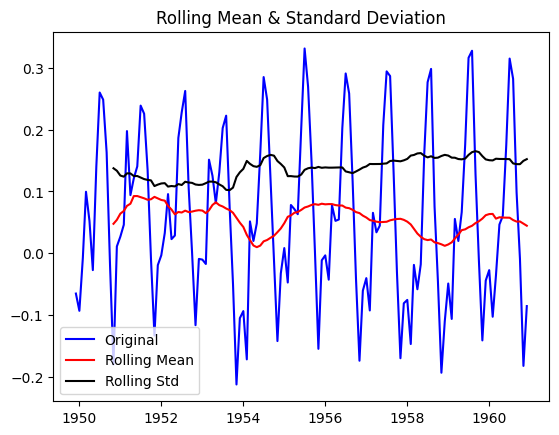

Results of Dickey Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [26]:
test_stationarity(airpass_new)

From the above plot, we came to know that "indeed subtracting two related series having similar trend components actually removed trend and made the dataset stationary"

Also, after concluding the results from ADFC test:

p-value has reduced from 0.99 to 0.022
Critical values at 1%,5%,10% confidence intervals are pretty close to the Test Statistic
So we can now say that given series is now STATIONARY

## Time Shift Transformation

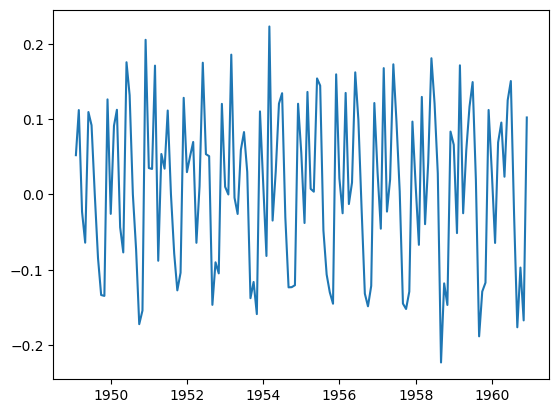

In [27]:
airpass_log_diff = airpass_log - airpass_log.shift()
plt.plot(airpass_log_diff)

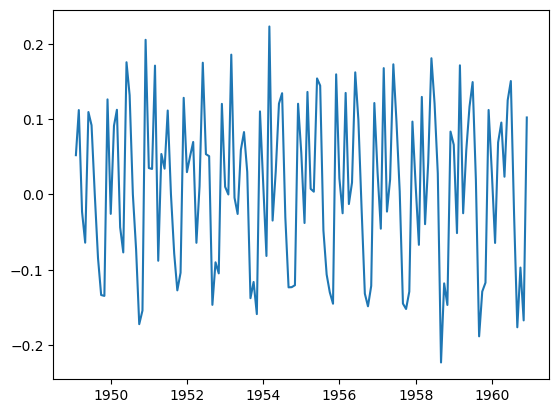

In [28]:
airpass_log_diff.dropna(inplace=True)
plt.plot(airpass_log_diff)

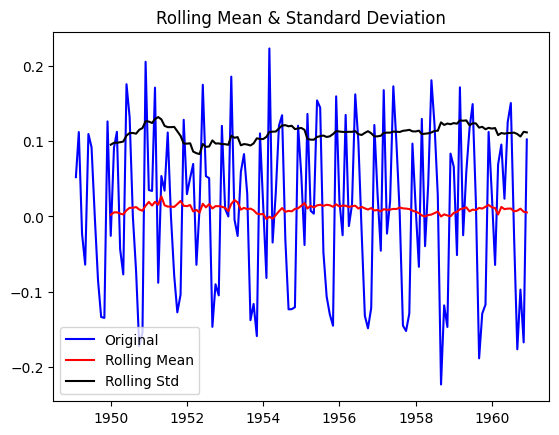

Results of Dickey Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [29]:
test_stationarity(airpass_log_diff)

From above plot, we can see that, visually this is the very best result as our series along with rolling stats values of moving avg(mean) & moving standard deviation is very much flat & stationary.

But, the ADCF test shows us that:

p-value of 0.07 is not as good as 0.02 of previous instance.
Test Statistic value not as close to the critical values as that of previous instance.

Let us now break down the 3 components of the log scale series using a system libary function. Once, we separate our the components, we can simply ignore trend & seasonality and check on the nature of the residual part.

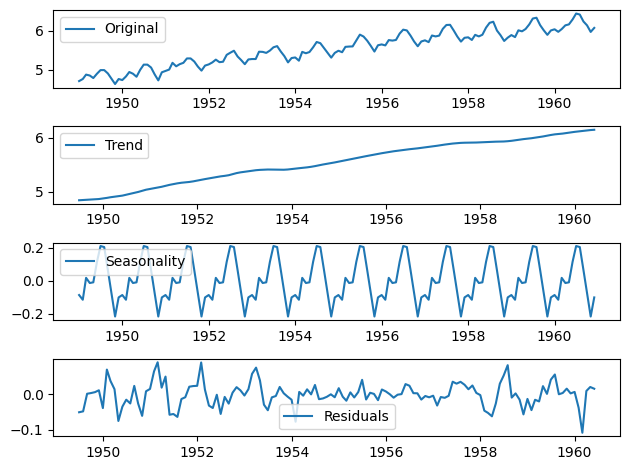

In [30]:
decomposition = seasonal_decompose(airpass_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(airpass_log, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()


In [31]:
airpass_decompose = residual
airpass_decompose.dropna(inplace=True)

Text(0.5, 1.0, 'Rolling Mean & Standard Deviation')

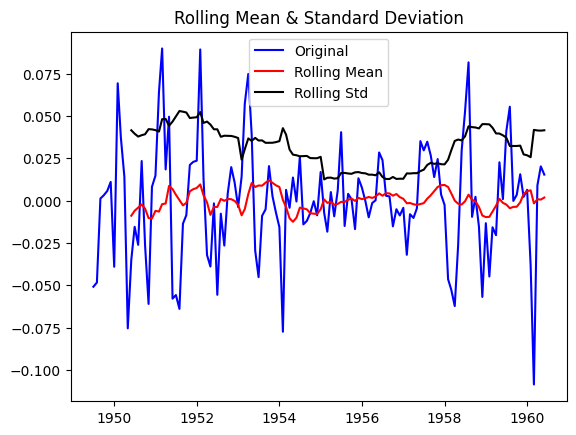

In [32]:
rollmean_decompose = airpass_decompose.rolling(window=12).mean()
rollstd_decompose = airpass_decompose.rolling(window=12).std()

plt.plot(airpass_decompose, color='blue', label='Original')
plt.plot(rollmean_decompose, color='red', label='Rolling Mean')
plt.plot(rollstd_decompose, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')

## Plotting ACF & PACF

In [33]:
lag_acf = acf(airpass_log_diff, nlags=20)
lag_pacf = pacf(airpass_log_diff, nlags=20, method='ols')

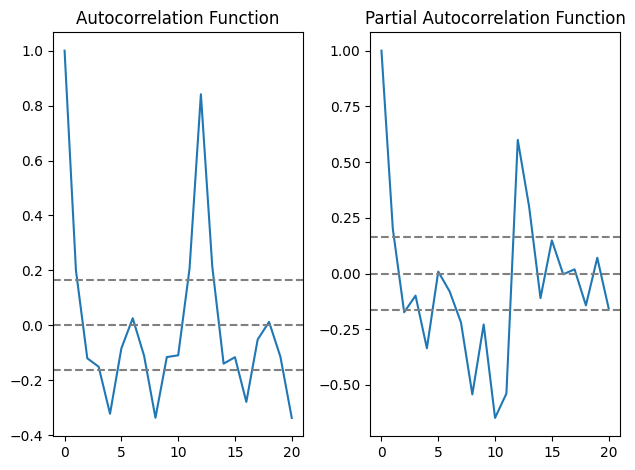

In [34]:
#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(airpass_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(airpass_log_diff)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(airpass_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(airpass_log_diff)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')

plt.tight_layout()

From the ACF graph, we can see that curve touches y=0.0 line at x=2. Thus, from theory, Q = 2 From the PACF graph, we see that curve touches y=0.0 line at x=2. Thus, from theory, P = 2

ARIMA is AR + I + MA. Before, we see an ARIMA model, let us check the results of the individual AR & MA model. Note that, these models will give a value of RSS. Lower the RSS values indicates a better model.

### AR Model

Making order = (2,1,0)

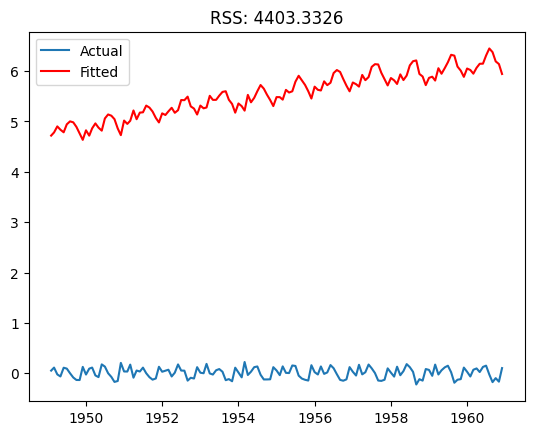

In [35]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import pandas as pd

# Fit the model
model1 = ARIMA(airpass_log, order=(2,1,0))
results_AR = model1.fit()

# Get fitted values and true values (differenced series)
fitted = results_AR.fittedvalues
true = airpass_log_diff['Passengers']

# Align both series to ensure same length and index
fitted, true = fitted.align(true, join='inner')

# Drop any NaNs just to be safe
fitted = fitted.dropna()
true = true.dropna()

# Final alignment to same index (in case dropping caused mismatch)
fitted, true = fitted.align(true, join='inner')

# Calculate RSS (Residual Sum of Squares)
rss = sum((fitted - true) ** 2)

# Plot
plt.plot(true, label='Actual')
plt.plot(fitted, color='red', label='Fitted')
plt.legend()
plt.title('RSS: %.4f' % rss)
plt.show()


## MA Model

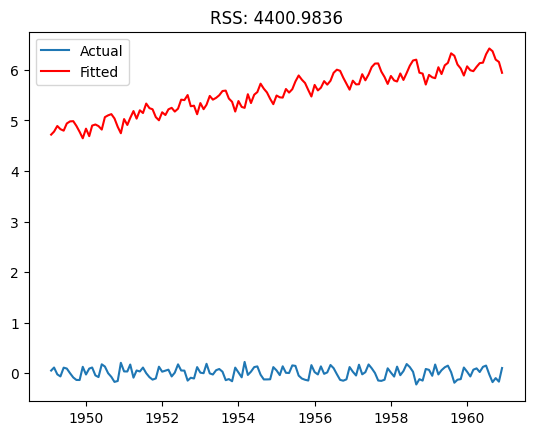

In [36]:
# Fit the model
model2 = ARIMA(airpass_log, order=(0,1,2))
results_MA = model2.fit()

# Get fitted values and true values (differenced series)
fitted = results_MA.fittedvalues
true = airpass_log_diff['Passengers']

# Align both series to ensure same length and index
fitted, true = fitted.align(true, join='inner')

# Drop any NaNs just to be safe
fitted = fitted.dropna()
true = true.dropna()

# Final alignment to same index (in case dropping caused mismatch)
fitted, true = fitted.align(true, join='inner')

# Calculate RSS (Residual Sum of Squares)
rss = sum((fitted - true) ** 2)

# Plot
plt.plot(true, label='Actual')
plt.plot(fitted, color='red', label='Fitted')
plt.legend()
plt.title('RSS: %.4f' % rss)
plt.show()

## AR+I+MA = ARIMA Model

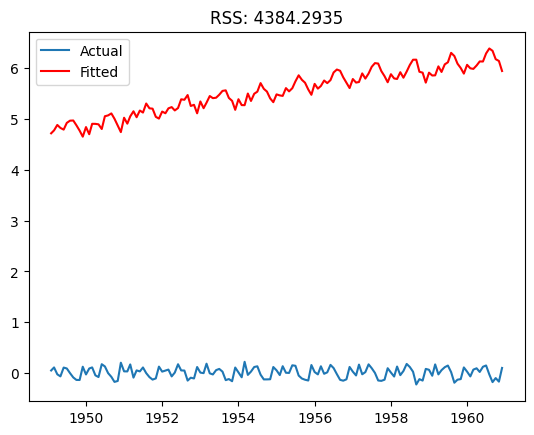

In [37]:
# Fit the model
model3 = ARIMA(airpass_log, order=(2,1,2))
results_ARIMA = model3.fit()

# Get fitted values and true values (differenced series)
fitted = results_ARIMA.fittedvalues
true = airpass_log_diff['Passengers']

# Align both series to ensure same length and index
fitted, true = fitted.align(true, join='inner')

# Drop any NaNs just to be safe
fitted = fitted.dropna()
true = true.dropna()

# Final alignment to same index (in case dropping caused mismatch)
fitted, true = fitted.align(true, join='inner')

# Calculate RSS (Residual Sum of Squares)
rss = sum((fitted - true) ** 2)

# Plot
plt.plot(true, label='Actual')
plt.plot(fitted, color='red', label='Fitted')
plt.legend()
plt.title('RSS: %.4f' % rss)
plt.show()



RSS value for: AR Model - 4403.3326 MA Model - 4400.36


ARIMA Model - 4384.2935

By combining AR & MA into ARIMA, we see that RSS value has decreased from either case to 1.0292, indicating ARIMA to be better than its individual component models.

With the ARIMA model built, we will now generate predictions. But, before we do any plots for predictions ,we need to reconvert the predictions back to original form. This is because, our model was built on log transformed data.

## Prediction & Reverse Transformation¶

In [38]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

,0
Month,
1949-01-01,0.000000
1949-02-01,4.718499
1949-03-01,4.776385
1949-04-01,4.883216
1949-05-01,4.824422


In [39]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

,0
Month,
1949-01-01,0.000000
1949-02-01,4.718499
1949-03-01,9.494884
1949-04-01,14.378100
1949-05-01,19.202522


In [40]:
predictions_ARIMA_log = pd.Series(airpass_log['Passengers'].iloc[0], index=airpass_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head()

,0
Month,
1949-01-01,4.718499
1949-02-01,9.436998
1949-03-01,14.213383
1949-04-01,19.096599
1949-05-01,23.921021


## Inverse of log is exp

In [41]:
print(predictions_ARIMA_log.describe())
print("NaNs:", predictions_ARIMA_log.isna().sum())
print("Infs:", np.isinf(predictions_ARIMA_log).sum())


count    144.000000
mean     382.856782
std      231.270467
min        4.718499
25%      181.874637
50%      373.843910
75%      579.573763
max      795.145015
dtype: float64
NaNs: 0
Infs: 0


In [42]:
# Drop any invalid values BEFORE applying exp
predictions_ARIMA_log_clean = predictions_ARIMA_log.dropna()
predictions_ARIMA_log_clean = predictions_ARIMA_log_clean[~np.isinf(predictions_ARIMA_log_clean)]

# Optionally clip large values to avoid overflow in np.exp
predictions_ARIMA_log_clean = predictions_ARIMA_log_clean.clip(upper=10)

In [43]:
predictions_ARIMA = np.exp(predictions_ARIMA_log_clean)


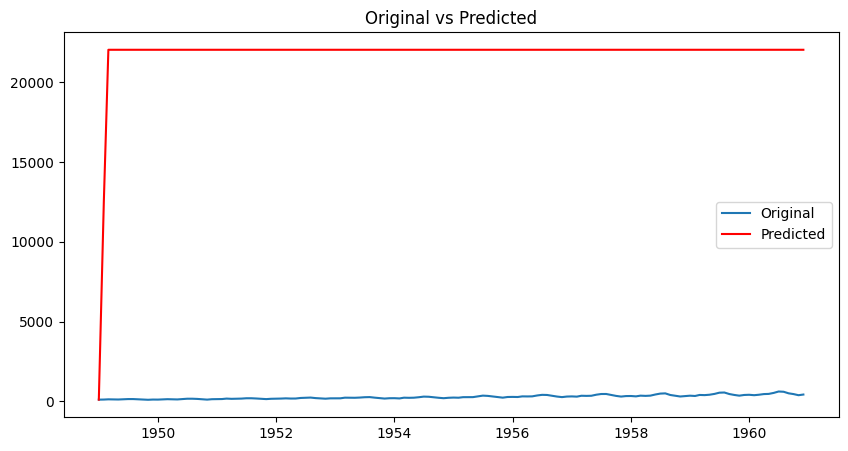

In [44]:
airpass_clean = airpassind_df.loc[predictions_ARIMA.index]  # align index

plt.figure(figsize=(10,5))
plt.plot(airpass_clean, label='Original')
plt.plot(predictions_ARIMA, color='red', label='Predicted')
plt.legend()
plt.title('Original vs Predicted')
plt.show()



In [45]:
# from statsmodels.tsa.arima.model import ARIMA

# model = ARIMA(airpass_log, order=(2,1,2))
# results_ARIMA = model.fit()


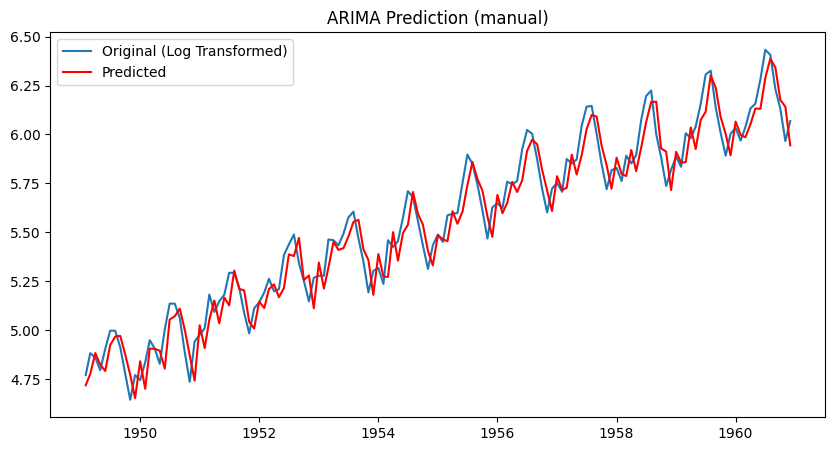

In [46]:
import matplotlib.pyplot as plt

# Predict starting from index 1 to the end
pred = results_ARIMA.predict(start=1, end=len(airpass_log)-1, typ='levels')

# Align original data for comparison
original = airpass_log[1:]  # Because d=1, first point is lost

# Plot
plt.figure(figsize=(10,5))
plt.plot(original, label='Original (Log Transformed)')
plt.plot(pred, color='red', label='Predicted')
plt.legend()
plt.title("ARIMA Prediction (manual)")
plt.show()
